<a href="https://colab.research.google.com/github/mchivuku/deep-learning-e533/blob/master/Homework4_Speaker_Verification_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Speaker Verification - Siamese Network

## Connect to google drive

In [0]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My\ Drive/Masters-DS/Deep\ Learning\ -\ E533/


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Masters-DS/Deep Learning - E533


In [0]:
%ls

homework_4.pdf  hw4_te7.pkl  hw4_tes.pkl  hw4_tr7.pkl  hw4_trs.pkl


[Errno 2] No such file or directory: 'Homework4'
/content/drive/My Drive/Masters-DS/Deep Learning - E533/Homework4


## Install Libraries

In [0]:
# Install librosa and other audio libraries

%%capture
!apt install ffmpeg
!pip install tensorpack
!pip install pydub
!pip install pysoundfile
!pip install librosa
!pip install livelossplot

## Libraries

In [0]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import os
import numpy as np

## Plot libraries
import matplotlib.pyplot as plt

%matplotlib inline

import torch.optim as optim

## Plotting library

from bokeh.plotting import figure
from bokeh.io import show
from bokeh.models import LinearAxis, Range1d


from livelossplot import PlotLosses


print('Torch', torch.__version__, 'CUDA', torch.version.cuda)
print('Device:', torch.device('cuda:0'))
print(torch.cuda.is_available())

is_cuda = torch.cuda.is_available()
device = torch.device ( "cuda:0" if torch.cuda.is_available () else "cpu" )

Torch 1.0.1.post2 CUDA 10.0.130
Device: cuda:0
True


In [0]:
import pickle

def load_pickle(file):
  with open(file, 'rb') as f:
    data = pickle.load(f)
  return data


train = load_pickle("hw4_trs.pkl")
test = load_pickle("hw4_tes.pkl")

print(f"Train: {train.shape}, test:{test.shape}")

train = np.array(train)
test = np.array(test)

Train: (500, 16180), test:(200, 22631)


## Audio Helpers functions

In [0]:
## Load Audio Helpers
import librosa.display
import numpy as np
import torch.nn
from IPython.display import display, Audio
from livelossplot import PlotLosses
import librosa

## Load all the files
def convert_to_stft(audio):
  S=librosa.stft(audio, n_fft=1024, hop_length=512)
  return S

'''
Load .wav file
'''
def load_wav(path, sr=None):
    s, sr=librosa.load(path, sr=None)
    return (s, sr)


"""
Plot stft
"""
def plot_spectogram(stft_matrix):
  librosa.display.specshow(librosa.amplitude_to_db(abs(stft_matrix)), sr=16000, hop_length=512, x_axis='time', y_axis='linear')
  plt.title("Spectrogram of  Signal")
  
  

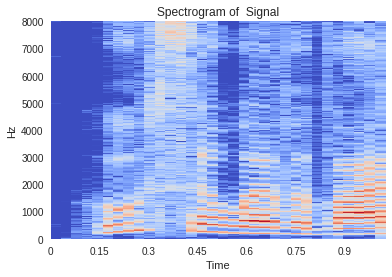

In [0]:
## Test
test1_stft =  convert_to_stft(train[0])
plot_spectogram(test1_stft)

In [0]:
## Plot Signal
sr = 16000
Audio(train[0],rate=16000)

## Build Speaker Pairs, Train and Test minibatches

In [0]:
##
import numpy as np
from itertools import combinations 


L = 25


"""
Get L pair of positive examples
"""
def get_L_pos_pairs(data,speakerindex,n = 500,num_speakers = 50):
  indices = list(range(speakerindex,n,num_speakers))
  total_combinations = np.array(list(combinations(indices,2)))
  i = np.random.permutation(np.arange(len(total_combinations)))
  return [(data[p1],data[p2]) for (p1,p2) in total_combinations[:L]]



"""
Get L pair of negative examples
"""
def get_L_neg_pairs(data, speakerindex,n = 500,num_speakers = 50):
  first_speaker = list(range(1,n,num_speakers))
  x = filter(lambda x: x not in first_speaker,range(n))
  x = list(x)
  L_pairs = []
  for i in range(L):
    pair1 = np.random.choice(first_speaker,size=1,replace=True)
    pair2 = np.random.choice(x,size=1,replace=False)
    L_pairs.append((pair1[0],pair2[0]))
 
  return [(data[p1],data[p2]) for (p1,p2) in L_pairs]
   
 
  
  

In [0]:
import random
class CustomDataLoader(torch.utils.data.Dataset):
  def __init__(self,istrain,data):
    self.data = data
    self.istrain = istrain
    if self.istrain:
      n = 500
      num_speakers = 50
      L = 25
      
         
      ## Create Pairs
      self.train_data = []
      self.train_labels = []
      
      for i in range(50):
        
        pos = get_L_pos_pairs(data,i,n,num_speakers)
        neg = get_L_neg_pairs(data,i,n,num_speakers)
        
        for indx in range(len(pos)):
          stft1_pos = convert_to_stft(pos[indx][0])
          sftp1_pos = np.abs(stft1_pos).T
          po1 = abs(sftp1_pos)
          
          stft2_pos = convert_to_stft(pos[indx][1])
          sftp2_pos = np.abs(stft2_pos).T
          
          po2 = abs(sftp2_pos)
          
          
          stft2_neg = convert_to_stft(neg[indx][1])
          stft2_neg = np.abs(stft2_neg).T
          neg1 = abs(stft2_neg)
          
          self.train_data.append(torch.stack([
                  torch.from_numpy(po1), 
                  torch.from_numpy(po2), 
                  torch.from_numpy(neg1)]))
        
          self.train_labels.append([1,0])
          
      self.train_data = torch.stack(self.train_data)
      self.train_labels = torch.tensor(self.train_labels)
      
    else:
      n = 200
      num_speakers = 20
      L = 10
      frame_length = 32
      self.test_data = []
      self.test_labels = []
      
      for i in range(num_speakers):
        
        pos = get_L_pos_pairs(data,i,n,num_speakers)
        neg = get_L_neg_pairs(data,i,n,num_speakers)
        
        for indx in range(len(pos)):
          stft1_pos = convert_to_stft(pos[indx][0])
          pos1 = abs(stft1_pos.T)
          
          pos1 = pos1[:frame_length,:]
          
          
          stft2_pos = convert_to_stft(pos[indx][1])
          pos2 = abs(stft2_pos.T)
          pos2 = pos2[:frame_length,:]
          
          stft2_neg = convert_to_stft(neg[indx][1])
          neg1 = abs(stft2_neg.T)
          neg1 = neg1[:frame_length,:]
          
          
          self.test_data.append(torch.stack([
                  torch.from_numpy(pos1), 
                  torch.from_numpy(pos2), 
                  torch.from_numpy(neg1)]))
        
          self.test_labels.append([1,0])
          
      
      self.test_data = torch.stack(self.test_data)
      self.test_labels = torch.tensor(self.test_labels)
    
  def __getitem__(self, index):
    if self.istrain:
       inputs, target = self.train_data[index], self.train_labels[index]
    else:
       inputs, target = self.test_data[index], self.test_labels[index]

    return inputs, target

  def __len__(self):
    if self.istrain:
      return len(self.train_data)
    else:
      return len(self.test_data)
   
  
batch_size = 1   
train_loader = torch.utils.data.DataLoader(CustomDataLoader(istrain=True,data=train), batch_size = 1,shuffle=False)
test_loader = torch.utils.data.DataLoader(CustomDataLoader(istrain=False,data=test), batch_size=1, shuffle=False)
      


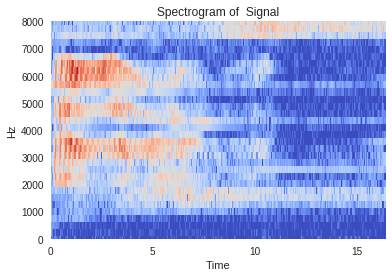

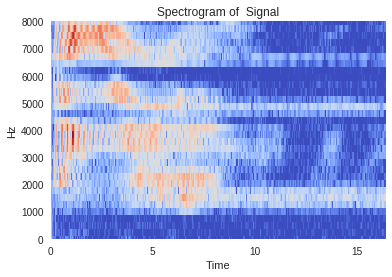

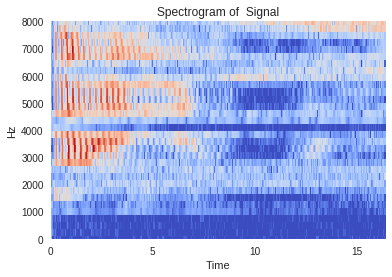

torch.Size([32, 513])

In [0]:
sample = next(iter(test_loader))
plot_spectogram(sample[0][0][0])
plt.show()
plot_spectogram(sample[0][0][1])
plt.show()
plot_spectogram(sample[0][0][2])
plt.show()

sample[0][0][0].shape

## Build Network

In [0]:
"""
Build Siamese Network
"""
class SiameseNetwork(nn.Module):
  
  def __init__(self):
      super(SiameseNetwork, self).__init__()
      self.layer1 = nn.Sequential(
          nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2))
      self.layer2 = nn.Sequential(
          nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2))
      self.drop_out = nn.Dropout()
      self.fc1 = nn.Linear(65536, 1000)
      self.fc2 = nn.Linear(1000, 2)
    
  
  """
  Forward
  """
  def forward(self, data):
      res = []
      for i in range(2): # Siamese nets; sharing weights
        x = data[0][i]
        x = x.unsqueeze(0)
        x = x.unsqueeze(0)
        x = self.layer1(x)
        x = self.layer2(x)
        x = F.relu(x)
        
        x = x.view(-1, self.num_flat_features(x))
        x = self.fc1(x)
        x = F.relu(x)
        res.append(F.relu(x))
         
      res = torch.abs(res[1] - res[0])
      
      return torch.sigmoid(self.fc2(res))
    
  def num_flat_features(self, x):
    size = x.size()[1:]  # all dimensions except the batch dimension
    num_features = 1
    for s in size:
        num_features *= s
        
    return num_features

In [0]:
model = SiameseNetwork()


In [0]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

## Train Network

In [0]:
"""
Train network
"""
#criterion = ContrastiveLoss()
loss_fn = nn.CrossEntropyLoss()

def train(model, train_mini_batch, epoch, optimizer):
  model.train()
  for batch_idx, (data, target) in enumerate(train_loader):
         
      optimizer.zero_grad()
      output_positive = model(data[:2])
      output_negative = model(data[0:3:2])
      
      
      target = target.type(torch.LongTensor)
      
      loss_positive = F.cross_entropy(output_positive,target[:,0])
      loss_negative = F.cross_entropy(output_negative, target[:,1])

      loss = loss_positive+loss_negative
      loss.backward()
      
      optimizer.step()
      if batch_idx % 10 == 0:
         print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx*batch_size, len(train_loader.dataset), 100. * batch_idx*batch_size / len(train_loader.dataset),
            loss.item()))
    
      


## Test Network

In [0]:
def test(model, test_loader):
  model.eval()
  target_pos = torch.ones(2)
  target_neg = torch.zeros(2)
  
  with torch.no_grad():
    accurate_labels = 0
    all_labels = 0
    loss = 0
    for batch_idx, (data, target) in enumerate(test_loader):
      optimizer.zero_grad()
      output_positive = model(data[:2])
      output_negative = model(data[0:3:2])
      
      
      target_positive = torch.squeeze(target[:,0])
      target_negative = torch.squeeze(target[:,1])
      
      accurate_labels_positive = torch.sum(torch.argmax(output_positive, dim=1) == target_positive).cpu()
      accurate_labels_negative = torch.sum(torch.argmax(output_negative, dim=1) == target_negative).cpu()

      accurate_labels = accurate_labels + accurate_labels_positive + accurate_labels_negative
      all_labels = all_labels + 2

      accuracy = 100. * accurate_labels / all_labels
      print('Test accuracy: {}/{} ({:.3f}%)\tLoss: {:.6f}'.format(accurate_labels, all_labels, accuracy, loss))
   

## Run Network

In [0]:
lr= 0.001
weight_decay = 0.0001

optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
num_epochs = 10
save_frequency = 10
for epoch in range(num_epochs):
  train(model, train_loader, epoch, optimizer)
  test(model, test_loader)
  

Test accuracy: 1/2 (50.000%)	Loss: 0.000000
Test accuracy: 2/4 (50.000%)	Loss: 0.000000
Test accuracy: 3/6 (50.000%)	Loss: 0.000000
Test accuracy: 4/8 (50.000%)	Loss: 0.000000
Test accuracy: 5/10 (50.000%)	Loss: 0.000000
Test accuracy: 6/12 (50.000%)	Loss: 0.000000
Test accuracy: 7/14 (50.000%)	Loss: 0.000000
Test accuracy: 8/16 (50.000%)	Loss: 0.000000
Test accuracy: 9/18 (50.000%)	Loss: 0.000000
Test accuracy: 10/20 (50.000%)	Loss: 0.000000
Test accuracy: 11/22 (50.000%)	Loss: 0.000000
Test accuracy: 12/24 (50.000%)	Loss: 0.000000
Test accuracy: 13/26 (50.000%)	Loss: 0.000000
Test accuracy: 14/28 (50.000%)	Loss: 0.000000
Test accuracy: 15/30 (50.000%)	Loss: 0.000000
Test accuracy: 16/32 (50.000%)	Loss: 0.000000
Test accuracy: 17/34 (50.000%)	Loss: 0.000000
Test accuracy: 18/36 (50.000%)	Loss: 0.000000
Test accuracy: 19/38 (50.000%)	Loss: 0.000000
Test accuracy: 20/40 (50.000%)	Loss: 0.000000
Test accuracy: 21/42 (50.000%)	Loss: 0.000000
Test accuracy: 22/44 (50.000%)	Loss: 0.000000
T